In [1]:
import numpy as np
import pandas as pd
import sys
import os
import math
import cv2


import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import *

from sklearn.model_selection import train_test_split, StratifiedKFold


CLASS_NUM            = 3  # test2 -1000
IMG_SIZE             = 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)
LR                   = 0.00002

In [2]:
#Строим модель отличающую человека от фото test 13
#Загружаем предобученную сеть Xception:
base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)

#base_model.trainable = False
#base_model.summary()
#Устанавливаем новую «голову» (head):
x = base_model.output
x = GlobalAveragePooling2D()(x)  #Pooling слой
x = BatchNormalization()(x) #добавим Batch нормализацию
x = Dense(256, activation='elu')(x) # полносвязный слой с активацией elu
x = Dropout(0.25)(x) # полносвязный слой с вероятность отключения нейронов в слое
predictions = Dense(CLASS_NUM, activation='softmax')(x) #логистический слой c 3 классами


model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [3]:
model.load_weights('./test13(1).hdf5')

In [4]:
#функция для создания триплетов, ожидает что переменные
# img1, img2, img3 существуют и не пусты
def mix_frame(new_img):
    """конкатинирует 3 кадра в одну картинку, не ищет лицо"""
    global img1 
    global img2
    global img3
    #global save_path

    img3 = img2
    img2 = img1
    img1 = new_img
    
    img0 = np.empty((new_img.shape[0],new_img.shape[1],3))

    imgGray = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
    imgGray1 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
    imgGray2 = cv2.cvtColor(img3,cv2.COLOR_BGR2GRAY)
 
    
    img0[:,:,0] = imgGray
    img0[:,:,1] = imgGray1
    img0[:,:,2] = imgGray2
    
    #cv2.imwrite(save_path, img0)
    return img0

In [5]:
#создадим перременные для предыдущей функции
img1 = cv2.imread('./photo0.jpg')
img2 = cv2.imread('./photo1.jpg')
img3 = cv2.imread('./photo2.jpg')
save_path = './sample_data/'

In [6]:
#протестируем
mix_img = cv2.imread('./p0 (10).png')

image = cv2.imread('./p0 (10).png')[..., ::-1]
image3 = cv2.resize(image, (224, 224))/255
pred = model.predict(image3[None, ...])
print(pred)
predictions = np.argmax(pred, axis=-1)
print(predictions)

[[0.5351744  0.2768065  0.18801899]]
[0]


In [7]:
#функция детектор принимает кадр, возвращает решение модели
num_detect = 0
def my_detector(frame):
    
    global num_detect

    mix_img = mix_frame(frame)

    num_detect += 1
    cv2.imwrite('./kkkk/'+str(num_detect)+'p.jpg', mix_img) #сохранение триплетов

    
    
    #mix_img
    mix_img = mix_img[0:480, 0:590]
    image = mix_img[..., ::-1]
    image3 = cv2.resize(image, (224, 224))/255
    pred = model.predict(image3[None, ...])
  
    return pred

In [8]:
#тестовые изображения
new_img = cv2.imread('./photo0.jpg')
#new_img1 = cv2.imread('/content/sample_data/photoN.jpg')
my_detector(new_img)

array([[0.09765058, 0.8497672 , 0.05258213]], dtype=float32)

In [9]:
from retina_unit1 import *

In [10]:
import os
import zipfile
from dataclasses import dataclass

from absl import logging
import tqdm
import random
import tensorflow as tf
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
import cv2
import matplotlib.pyplot as plt

import yaml
import sys
import time

from tensorflow.keras.utils import plot_model

import copy

import numpy as np

%matplotlib inline

In [11]:
#поместим чекпоинт в паку где модель ожидает его найти
#os.mkdir("./checkpoints")
#os.mkdir("./checkpoints/retinaface_res50")

In [12]:
# Зададим настройки модели
BATCH_SIZE = 12 
EPOCHS = 1

## Настройки конфигов обучения
MODELS_CONFIG = {
    'MobileNetV2': {
        'cfg_path': f'./retinaface_res50.yaml',
        'dataset_path': f'./widerface/widerface_train_bin.tfrecord',
        'batch_size': BATCH_SIZE,
        'testing_dataset_path': f'./widerface/val',
        'epoch': EPOCHS
    }
}

# Выберем backbone для RetinaFace
backbone_model = 'MobileNetV2'

dataset_path = MODELS_CONFIG[backbone_model]['dataset_path']
cfg_path = MODELS_CONFIG[backbone_model]['cfg_path']
batch_size = MODELS_CONFIG[backbone_model]['batch_size'] 
testing_dataset_path = MODELS_CONFIG[backbone_model]['testing_dataset_path']
epoch = MODELS_CONFIG[backbone_model]['epoch']

custom_config_path = f'./retinaface_res50.yaml'

In [13]:
retina_detector = RetinaFace(custom_config_path)

In [14]:
retina_detector.is_fitted = True

In [15]:
y_pred = retina_detector.predict(new_img)

In [16]:
#протестируем
y_pred

{'outputs': [array([[0.1878241 , 0.19831917, 0.484279  , 0.75450337, 0.27452168,
          0.4396467 , 0.41238263, 0.4344397 , 0.3504326 , 0.5695876 ,
          0.29064745, 0.635073  , 0.40166876, 0.62920254, 1.        ,
          0.9999994 ]], dtype=float32)],
 'image_params': [(640, 480)]}

In [17]:
height = y_pred['image_params'][0][1]
width = y_pred['image_params'][0][0]
x0 = round(y_pred['outputs'][0][0][0]*width)
y0 = round(y_pred['outputs'][0][0][1]*height)
x1 = round(y_pred['outputs'][0][0][2]*width)
y1 = round(y_pred['outputs'][0][0][3]*height)

In [18]:
image6 = cv2.rectangle(new_img,
              (x0, y0), (x1, y1),
              (0,155,255),
              2)

In [19]:
############# ArcFace

In [20]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import *
import keras.backend as K
from keras.models import Sequential

# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.
RANDOM_SEED          = 100

EPOCHS               = 10  # эпох на обучение
BATCH_SIZE           = 64 # 
LR                   = 0.0001/32
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 1016 
IMG_SIZE             = 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [21]:
def ArcFaceLoss(W, m, s):
    def inner(y_true, x):
        # replace 0 => 1 and 1=> m in y_true
        M = (m-1) * y_true + 1
        
        # W . x = ||W||*||x||*cos(theta)
        # but ||W|| = 1 and ||x|| = 1
        # so (W . x) = cos(theta) 
        dot_product = tf.matmul(x, W)
        cos_theta,cos_theta_norms = tf.linalg.normalize(dot_product,axis=0)

        theta = tf.acos(cos_theta)
    
        # add appropriate margin to theta
        new_theta = theta + M
        new_cos_theta = tf.cos(new_theta)
    
        # re-scale the cosines by a hyper-parameter s
        y_pred = s * new_cos_theta     

        # the following part is the same as softmax loss
        numerators = tf.reduce_sum(y_true * tf.exp(y_pred), axis=1)
        denominators = tf.reduce_sum(tf.exp(y_pred), axis=1)
        loss = - tf.reduce_sum(K.log(numerators / denominators))
    
        return loss

    return inner

In [22]:
#Строим модель
#Загружаем предобученную сеть :
#base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)
Abase_model = ResNet101(weights='imagenet', include_top=False, input_shape = input_shape)
#base_model.trainable = False
#base_model.summary()
#Устанавливаем новую «голову» (head):
A = Abase_model.output
A = GlobalAveragePooling2D()(A)  #Pooling слой
A = BatchNormalization()(A) #добавим Batch нормализацию
A = Dense(512, activation='elu')(A) # полносвязный слой с активацией elu
A = Dropout(0.25)(A) # полносвязный слой с вероятность отключения нейронов в слое
predictions = Dense(CLASS_NUM, activation='sigmoid')(A) #логистический слой c 2 классами

predictions.trainable = False

#model = Model(inputs=base_model.input, outputs=predictions)
arcface = tf.keras.models.Model(inputs=Abase_model.input, outputs=[A, predictions])


def dummy_loss(ytrue, ypred):
    return tf.constant([0])

#loss_func = CosFaceLoss(W=model.layers[-1].weights[0], m=10.0, s=10.0)
loss_func = ArcFaceLoss(W=model.layers[-1].weights[0], m=0.2, s=10.0)

arcface.compile(loss=[loss_func, dummy_loss], optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [23]:
arcface.load_weights('./dvc(15).hdf5')

In [24]:
image = cv2.imread('./photo1.jpg')[..., ::-1]
image3 = cv2.resize(image, (224, 224))/255
v1 = arcface.predict(image3[None, ...])[0][0]

In [25]:
import pickle
pkl_file = open('./data.pkl', 'rb')
v1 = pickle.load(pkl_file)
pkl_file.close()

In [30]:
#frame = cv2.imread('./photo0.jpg')
import cv2
import serial
import copy
import time
import scipy.spatial.distance as ds
valid = 0

ser = serial.Serial(
    port = 'COM3',\
    baudrate=9600,\
    parity=serial.PARITY_NONE,\
    stopbits=serial.STOPBITS_ONE,\
    bytesize=serial.EIGHTBITS,\
    timeout=0)

cap = cv2.VideoCapture(0,cv2.CAP_DSHOW)
while cap.isOpened():
    ret, frame = cap.read() 
    
    #cv2.rectangle(frame, (10, 10), (630, 470), (168,168,20) , 10)
    frame1 = copy.deepcopy(frame)
    
    #my_detector  
    
    t0 = time.time()
    
    my_class = my_detector(frame1)      

    if np.argmax(my_class, axis=-1) == 0:
        cv2.rectangle(frame, (10, 10), (630, 470), (20,168,168) , 10)
        ser.write(b'345')  #y
        valid = 0
    elif np.argmax(my_class, axis=-1) == 2: #my_class[0,2] > 0.5 or my_class[0,1] < 0.5:
        cv2.rectangle(frame, (10, 10), (630, 470), (20,20,168) , 10)
        ser.write(b'234')  #r
        valid = 0
    else:
        cv2.rectangle(frame, (10, 10), (630, 470), (20,168,20) , 10)
        ser.write(b'123')  #g
        valid = 1
    
    
    cv2.putText(frame,
                             "{:.2f}".format(float(my_class[0,0])),
                             (30, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                             (0,0,20),
                              2)  
    cv2.putText(frame,
                             "{:.2f}".format(float(my_class[0,1])),
                             (70, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                             (0,0,20),
                              2)
    cv2.putText(frame,
                             "{:.2f}".format(float(my_class[0,2])),
                             (110, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                             (0,0,20),
                              2)
    
    t1 = time.time()
    cv2.putText(frame,
                             "M_vs_P {:.2f}".format(float(t1-t0))+"s",
                             (500, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                             (0,0,20),
                              2)
        
    #my_detector 
    
    
   
    '''   
    t1 = time.time()
     
    #my_retina
    valid = 1
    if valid == 1:
        face = retina_detector.predict(frame)
        
        if len(face['outputs'][0]) > 0:
            height = face['image_params'][0][1]
            width = face['image_params'][0][0]
            x0 = round(face['outputs'][0][0][0]*width)
            y0 = round(face['outputs'][0][0][1]*height)
            x1 = round(face['outputs'][0][0][2]*width)
            y1 = round(face['outputs'][0][0][3]*height)

        cv2.rectangle(frame,(x0, y0), (x1, y1),  (0,155,255), 2)
        
    t2 =  time.time() 
    cv2.putText(frame,
                             "Retina {:.2f}".format(float(t2-t1))+"s",
                             (500, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                             (0,0,20),
                              2)
    out_face =  frame1[y0:y1, x0:x1]
                              
        
    #my_retina
      
    t2 =  time.time()  
    #ArcFace
    
    if len(face['outputs'][0]) > 0:
        image = out_face[..., ::-1]
        image3 = cv2.resize(image, (224, 224))/255
        v2 = arcface.predict(image3[None, ...])[0][0]
        dis_c = ds.cosine(v1, v2)
    else:
        dis_c = 0.0
    
    
    t3 =  time.time() 
    
    cv2.putText(frame,
                             "ArcFace {:.2f}".format(float(t3-t2))+"s",
                             (500, 70), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                             (0,0,20),
                              2)
    
    
    
    
    cv2.putText(frame,
                             "distance {:.2f}".format(float(dis_c)),
                             (500, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                             (0,0,20),
                              2)
    ''' 
    #ArcFace  
    
    cv2.imshow('Raw Webcam Feed', frame)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()
ser.close()

In [27]:
#frame = cv2.imread('./photo0.jpg')
#my_detector(frame)

In [13]:
import serial

In [26]:
ser = serial.Serial(
    port = 'COM3',\
    baudrate=9600,\
    parity=serial.PARITY_NONE,\
    stopbits=serial.STOPBITS_ONE,\
    bytesize=serial.EIGHTBITS,\
    timeout=0)

In [29]:
ser.write(b'345')


3

In [52]:
ser.close()

In [64]:
import pickle
pickle.DEFAULT_PROTOCOL
output = open('data.pkl', 'wb')
pickle.dump(v2, output)
output.close()

In [20]:
import cv2
#img = cv2.imread("lenna.png")
crop_img = img1[0:480, 60:640]

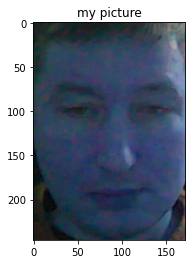

In [59]:
from PIL import Image
import matplotlib.pyplot as plt
#gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

plt.imshow(out_face)
plt.title('my picture')
plt.show()

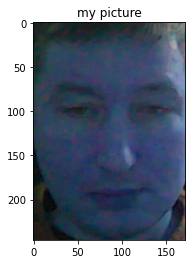

In [58]:
plt.imshow(out_face)
plt.title('my picture')
plt.show()